# Inicio

## Importação Bibliotecas

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
!pip install dateparser
import dateparser               
!pip install yfinance
import yfinance as yf
from statsmodels.tsa.stattools import grangercausalitytests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import yfinance as yf

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

Modelo Base

## Coletando o dataframe

In [56]:
# A função trat_datas padroniza o formato das datas criando uma coluna para mês e ano:

def trat_datas(df,coluna_data):
  df['ano'] = df.apply(lambda _: '', axis=1)
  df['mes'] = df.apply(lambda _: '', axis=1)

  for p,i in enumerate (df[coluna_data]):
    i = dateparser.parse(i)
    df['mes'].iloc[p] = df[coluna_data].iloc[p][3:5]
    df['ano'].iloc[p] = df[coluna_data].iloc[p][-4:]

  return df

#A função (get_bc_dataset(CodSerie)) coleta os dados da serie definida do Bacem e transforma em um pd.DataFrame
#Em seguida, executa a função trat_datas e agrupa os valores por mes e ano

def get_bc_dataset(CodSerie):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(CodSerie)
  raw_df =  pd.read_json(url)
  raw_df = raw_df.rename(columns={'valor': CodSerie})
  raw_df = trat_datas(raw_df,'data')
  raw_df = raw_df.groupby(by=["ano", "mes"], as_index=False).agg('mean')
  return raw_df

# A Função merge_datasets agrupa dois datasets a partir da chave desejada (no nosso caso é a data)

def merge_datasets(df1,df2,key):
  df = pd.merge(df1, df2,  how='left', left_on = key, right_on = key)
  return df

# Para ganharmos escalabilidade, a função get_pool realiza a função merge_datasets para uma lista de series do bacen a serem analisadas,
# ou seja, faz lago de dados (data lake) com os indicadores e kpis indicados (numero das series do bacem) em uma lista

def lago(lista_series_bc):

  df = pd.DataFrame(columns = ['ano','mes'])
  contador = 0
  for i in lista_series_bc:
    df_i = get_bc_dataset(i)
    if contador == 0:
      df = df_i
      contador += 1
    else:
      df = merge_datasets(df,df_i,['ano','mes'])
  return df

  
# A função merge_yfin tem como input uma lista de tickers da biblioteca yfinance (Yahoo Finance). A função utiliza uma API do yahoo finance para buscar os dados.
# Nesse trabalho, buscamos o dado do ibovespa, bitcoin, sgpsci e ouro

def merge_yfin(lista):

  inicio = '2005-01-01'
  fim = '2022-09-01'
  contador = 0
  df = pd.DataFrame(columns = ['Date','Adj Close'])
  for i in lista:
    df_i = yf.download(i, start = inicio, end = fim)['Adj Close']
    df_i = df_i.to_frame().reset_index()
    df_i = df_i.rename(columns = {'Adj Close' : '{}'.format(i)})
    df_i['ano'] = pd.DatetimeIndex(df_i['Date']).year
    df_i['mes'] = pd.DatetimeIndex(df_i['Date']).month
    df_i = df_i.groupby(by = ['ano','mes']).agg('mean').reset_index()
    if contador == 0:
      df = df_i
      contador += 1
    else:
      df = pd.merge(df, df_i,  how='left', left_on = ['ano','mes'], right_on = ['ano','mes'])
  return df

### Dados Bacen

Esse passo importa as séries temporais desejadas dos dados do Bacen:

https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries


Foram para o trabalhoselecionadas as séries:

1178 = Selic
432 = Meta Selic
189 = IGPM
433 = IPCA
13521 = Meta IPCA
27788 = M1
27810 = M2
1788 = Base monetária reestrita

Tempo de execução: 2min

In [57]:
lista_bacen = [1178,432,189,433,27788,27810,1788]
df = lago(lista_bacen)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py:507: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  return self._try_aggregate_string_function(obj, f, *self.args, **self.kwargs)


### Tratamentos iniciais

-Tratamento de datas: padronizando no formato inteiro e renomeando colunas
-Renomeando colunas

In [58]:
df['ano'] = df['ano'].astype(int)
df['mes'] = df['mes'].astype(int)
df = df.rename(columns={
    1178:'Selic',
    432:'Meta Selic',
    189:'IGPM',
    433:'IPCA',
    27788: 'M1',
    1788: 'Base monetária restrita'})

### Dados Yahoo Finance

Coletando dataframe da biblioteca do yahoo Yfinance a partir dos tickers abaixo:

^BVSP = Ibovespa
BTC-USD = Bitcoin em dólares
GC=F = Ouro futuro em dólares
^SPGSCI = Índice de commodities com foco em petróleo
ETH-USD = Ethereum em dólares

In [59]:
lista_Yfinance = ['^BVSP','BTC-USD','GC=F','^SPGSCI','ETH-USD','USDBRL=X']

df_y = merge_yfin(lista_Yfinance)
df_y = df_y.rename(columns = {'^BVSP': 'Ibovespa','GC=F':'Gold Futures (USD)', '^SPGSCI':'S&P GSCI','USDBRL=X':'USD_BRL'})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Junção dos dados do Bacen com os dados do Yahoo finance

In [60]:
df = pd.merge(df,df_y, how ='left',left_on = ['ano','mes'], right_on=['ano','mes'])

# Análise exploratória dos dados (EDA)

## Análise do dataset

In [61]:
df.head()

,ano,mes,Selic,Meta Selic,IGPM,IPCA,M1,Base monetária restrita,Ibovespa,BTC-USD,Gold Futures (USD),S&P GSCI,ETH-USD,USD_BRL
0,1986,6,18.232632,NaN,NaN,1.27,NaN,120553000.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1986,7,23.523478,NaN,NaN,1.71,NaN,137558000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1986,8,35.685714,NaN,NaN,3.55,NaN,145798000.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1986,9,39.389091,NaN,NaN,1.72,NaN,149852000.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1986,10,23.656522,NaN,NaN,1.90,NaN,157605000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
df.tail()

,ano,mes,Selic,Meta Selic,IGPM,IPCA,M1,Base monetária restrita,Ibovespa,BTC-USD,Gold Futures (USD),S&P GSCI,ETH-USD,USD_BRL
433,2022,7,13.150000,13.250000,0.21,-0.68,598041462.0,389598010.0,99108.571429,21539.253843,1729.800000,677.345505,1359.407778,5.371471
434,2022,8,13.584783,13.701613,-0.70,-0.36,596615321.0,395354595.0,110061.826087,22366.266318,1762.478261,668.935650,1699.230370,5.142541
435,2022,9,13.650000,13.750000,-0.95,-0.29,593692220.0,393440715.0,NaN,NaN,NaN,NaN,NaN,NaN
436,2022,10,13.650000,13.750000,-0.97,0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
437,2022,11,13.650000,13.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 0 to 437
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ano                      438 non-null    int64  
 1   mes                      438 non-null    int64  
 2   Selic                    438 non-null    float64
 3   Meta Selic               285 non-null    float64
 4   IGPM                     401 non-null    float64
 5   IPCA                     437 non-null    float64
 6   M1                       250 non-null    float64
 7   Base monetária restrita  436 non-null    float64
 8   Ibovespa                 212 non-null    float64
 9   BTC-USD                  96 non-null     float64
 10  Gold Futures (USD)       212 non-null    float64
 11  S&P GSCI                 212 non-null    float64
 12  ETH-USD                  58 non-null     float64
 13  USD_BRL                  198 non-null    float64
dtypes: float64(12), int64(2)
m

In [64]:
df.describe()

,ano,mes,Selic,Meta Selic,IGPM,IPCA,M1,Base monetária restrita,Ibovespa,BTC-USD,Gold Futures (USD),S&P GSCI,ETH-USD,USD_BRL
count,438.000000,438.000000,438.000000,285.000000,401.000000,437.000000,2.500000e+02,4.360000e+02,212.000000,96.000000,212.000000,212.000000,58.000000,198.000000
mean,2004.164384,6.527397,1946.228704,12.743822,4.930249,5.636773,2.811256e+08,3.045303e+09,65845.951957,12570.624178,1237.192132,500.368334,1112.268976,2.968983
std,10.552274,3.445945,23706.021979,5.802842,11.575857,11.703918,1.455287e+08,1.854937e+10,24565.634441,16447.968839,401.970917,125.685074,1221.900465,1.246319
min,1986.000000,1.000000,1.900000,2.000000,-1.100000,-0.680000,7.494224e+07,4.117000e+06,24432.900000,233.595533,422.295239,258.815241,108.998097,1.561390
25%,1995.000000,4.000000,10.900114,8.750000,0.280000,0.330000,1.614287e+08,5.582895e+07,50344.238636,643.380466,945.328287,402.042400,208.585375,1.956272
50%,2004.000000,7.000000,16.578345,12.183333,0.750000,0.600000,2.752274e+08,1.729840e+08,59913.650718,6832.261890,1264.775009,469.758241,474.736096,2.340418
75%,2013.000000,9.750000,42.601643,16.427419,1.750000,1.620000,3.429453e+08,2.836484e+08,77194.200658,12186.623173,1535.979926,624.515539,1727.598897,3.813680
max,2022.000000,12.000000,487832.588889,44.222222,83.950000,82.390000,6.279017e+08,2.421393e+11,128989.952381,60621.488802,1966.238084,832.309044,4434.128711,5.654038


In [65]:
df.isna().sum() # Verificação de valores nulos (sem dados naquela data)

ano                          0
mes                          0
Selic                        0
Meta Selic                 153
IGPM                        37
IPCA                         1
M1                         188
Base monetária restrita      2
Ibovespa                   226
BTC-USD                    342
Gold Futures (USD)         226
S&P GSCI                   226
ETH-USD                    380
USD_BRL                    240
dtype: int64

#Tratamento dos dados

##Tratamento Bitcoin

Esse passo mostra o ano mais antigo de cada variável do dataframe. Vamos coletar o df do período do Bitcoin.

In [66]:
df['BTC_BRL'] = df['BTC-USD'] * df['USD_BRL'] # Criando coluna convertendo bitcoin para reais

In [67]:
#A função retorna o ano do primeiro valor não nulo de cada coluna do df (data inicial)

for i in df.columns:
  print(i,': ',end='')
  print(df['ano'][df[i].first_valid_index()])

ano : 1986
mes : 1986
Selic : 1986
Meta Selic : 1999
IGPM : 1989
IPCA : 1986
M1 : 2001
Base monetária restrita : 1986
Ibovespa : 2005
BTC-USD : 2014
Gold Futures (USD) : 2005
S&P GSCI : 2005
ETH-USD : 2017
USD_BRL : 2006
BTC_BRL : 2014


In [68]:
df_btc = df[df['ano'] >= 2015]
df_btc = df_btc[:-3]
df_btc = df_btc.drop(columns = ['ETH-USD','Meta Selic'])


#Como começaram a aparecer dados do bitcoin em 2014. Utilizaremos como ponto de partida o ano de 2015.
#Em seguida, deletamos os últimos 3 meses para evitar valores nulols por não termos os dados mais recentes de algumas variáveis.
#Esses dados vão ser utilizados posteriormente para a matriz de causalidade granger

## Tratamento Correlações

In [69]:
df[['IPCA','IGPM']].corr() 

,IPCA,IGPM
IPCA,1.0000,0.9921
IGPM,0.9921,1.0000


In [70]:
df[['Selic','Meta Selic']].corr()

,Selic,Meta Selic
Selic,1.000000,0.999899
Meta Selic,0.999899,1.000000


In [71]:
df[['M1','Base monetária restrita']].corr()

,M1,Base monetária restrita
M1,1.000000,0.992778
Base monetária restrita,0.992778,1.000000


In [72]:
df[['BTC-USD','ETH-USD']].corr()

,BTC-USD,ETH-USD
BTC-USD,1.000000,0.929612
ETH-USD,0.929612,1.000000


Como essas correlações são muito próximas, não há necessidade de termos tantas variáveis. Vamos eliminar variáveis com correlações muito próximas a 1. Além disso, eliminar o ano e mês para a análise de correlações

In [73]:
#Filtrando variáveis desejadas:
#Dropando as colunas ano e mes para observar a correlação entre variáveis

df_corr = df[['ano','mes','BTC-USD','BTC_BRL','Selic','IGPM','M1','Ibovespa','Gold Futures (USD)','S&P GSCI']].drop(columns = ['ano','mes']) 
#df_corr_BTC_USD = df[['ano','mes','BTC-USD','BTC_BRL','Selic','IGPM','M1','Ibovespa','Gold Futures (USD)','S&P GSCI']].drop(columns = ['ano','mes']) 


In [74]:
df_corr.tail(15)

,BTC-USD,BTC_BRL,Selic,IGPM,M1,Ibovespa,Gold Futures (USD),S&P GSCI
423,45939.771484,241768.071526,5.435714,-0.64,614143783.0,113872.952381,1775.899995,538.905236
424,57911.970514,320175.150567,6.300000,0.64,604397556.0,110091.000000,1776.404750,583.894284
425,60621.488802,336846.331234,7.650000,0.02,599668025.0,104290.000000,1818.222717,573.469523
426,49263.209173,278536.062495,8.758696,0.87,621391736.0,105894.190476,1791.045443,545.649087
427,41114.422379,227667.374806,9.150000,1.82,596517645.0,106724.380952,1816.639996,596.979492
428,40763.474051,211885.187165,10.492105,1.83,590881954.0,112851.263158,1857.742091,645.033682
429,41966.237525,209297.737970,11.150000,1.74,592942148.0,115150.045455,1950.673902,747.958260
430,41435.319661,196112.579772,11.650000,1.41,599813109.0,115022.052632,1933.930005,740.148001
431,31706.105217,157290.027180,12.513636,0.52,597297282.0,107809.227273,1845.938099,764.009048
432,24383.685482,122712.920991,12.888095,0.59,601904463.0,103746.571429,1834.547619,773.668091


# Modelagem e Análise dos dados

##Análise Correlações

In [75]:
df_corr.corr() #Essa tabela mostra a correlaçã Pearson entre as variáveis

,BTC-USD,BTC_BRL,Selic,IGPM,M1,Ibovespa,Gold Futures (USD),S&P GSCI
BTC-USD,1.000000,0.996211,-0.413076,0.298005,0.865502,0.750769,0.779238,0.616871
BTC_BRL,0.996211,1.000000,-0.394890,0.309929,0.865410,0.722988,0.775012,0.589639
Selic,-0.413076,-0.394890,1.000000,0.449868,-0.741173,-0.775490,-0.715897,-0.043674
IGPM,0.298005,0.309929,0.449868,1.000000,0.137494,0.369349,0.328903,0.027988
M1,0.865502,0.865410,-0.741173,0.137494,1.000000,0.860982,0.829070,0.014774
Ibovespa,0.750769,0.722988,-0.775490,0.369349,0.860982,1.000000,0.742480,0.096461
Gold Futures (USD),0.779238,0.775012,-0.715897,0.328903,0.829070,0.742480,1.000000,0.285225
S&P GSCI,0.616871,0.589639,-0.043674,0.027988,0.014774,0.096461,0.285225,1.000000


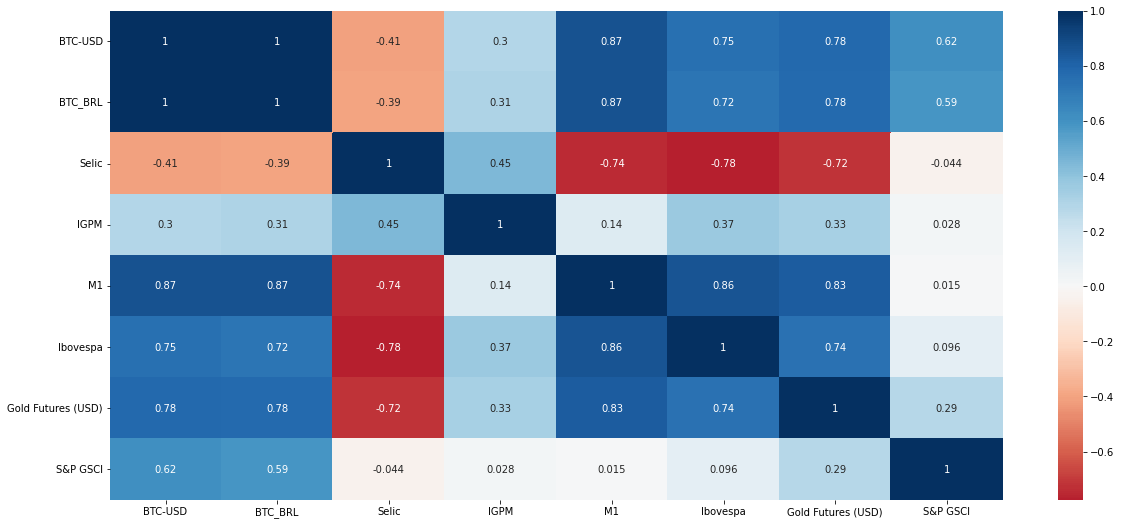

In [76]:
plt.figure(figsize = [20,9])

sns.heatmap(df_corr.corr(), center = 0,cmap="RdBu",annot = True)

In [77]:
df_btc.info() # Dropar colunas a partir das correlacoes 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 343 to 434
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ano                      92 non-null     int64  
 1   mes                      92 non-null     int64  
 2   Selic                    92 non-null     float64
 3   IGPM                     92 non-null     float64
 4   IPCA                     92 non-null     float64
 5   M1                       92 non-null     float64
 6   Base monetária restrita  92 non-null     float64
 7   Ibovespa                 92 non-null     float64
 8   BTC-USD                  92 non-null     float64
 9   Gold Futures (USD)       92 non-null     float64
 10  S&P GSCI                 92 non-null     float64
 11  USD_BRL                  92 non-null     float64
 12  BTC_BRL                  92 non-null     float64
dtypes: float64(11), int64(2)
memory usage: 10.1 KB


In [78]:
df_btc.head()

,ano,mes,Selic,IGPM,IPCA,M1,Base monetária restrita,Ibovespa,BTC-USD,Gold Futures (USD),S&P GSCI,USD_BRL,BTC_BRL
343,2015,1,11.816667,0.76,1.24,343797138.0,238524692.0,48369.380952,248.782547,1252.924994,388.270499,2.630450,654.410049
344,2015,2,12.150000,0.27,1.22,334090852.0,238815587.0,50131.444444,234.153645,1224.910522,412.936315,2.809120,657.765686
345,2015,3,12.581818,0.98,1.32,328802402.0,240656354.0,50405.227273,269.042259,1177.768183,403.384545,3.126173,841.072572
346,2015,4,12.677500,1.17,0.71,323912405.0,235020109.0,54495.850000,235.491534,1199.828578,423.742859,3.048159,717.815650
347,2015,5,13.150000,0.41,0.74,318914527.0,239513461.0,55807.500000,236.997001,1198.215009,443.379498,3.046357,721.977512


## Causalidade Granger

In [79]:
df_btc_granger = df_corr.dropna(axis = 0)

In [80]:
#Teste causalidade granger

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag = 5
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger = grangers_causation_matrix(df_btc_granger, variables = df_btc_granger.columns)

In [81]:
granger

,BTC-USD_x,BTC_BRL_x,Selic_x,IGPM_x,M1_x,Ibovespa_x,Gold Futures (USD)_x,S&P GSCI_x
BTC-USD_y,1.0000,0.0313,0.0020,0.0002,0.0000,0.0208,0.0006,0.0243
BTC_BRL_y,0.1739,1.0000,0.0023,0.0000,0.0000,0.0149,0.0003,0.0470
Selic_y,0.0000,0.0000,1.0000,0.0041,0.0000,0.0000,0.0000,0.0000
IGPM_y,0.2767,0.1512,0.0128,1.0000,0.0301,0.2527,0.0303,0.0567
M1_y,0.1973,0.1140,0.0100,0.2081,1.0000,0.0919,0.0000,0.0755
Ibovespa_y,0.3441,0.4561,0.0692,0.0062,0.0335,1.0000,0.1860,0.1536
Gold Futures (USD)_y,0.7743,0.6950,0.0679,0.4928,0.0091,0.0654,1.0000,0.0196
S&P GSCI_y,0.0000,0.0000,0.0233,0.0647,0.0001,0.0098,0.0006,1.0000


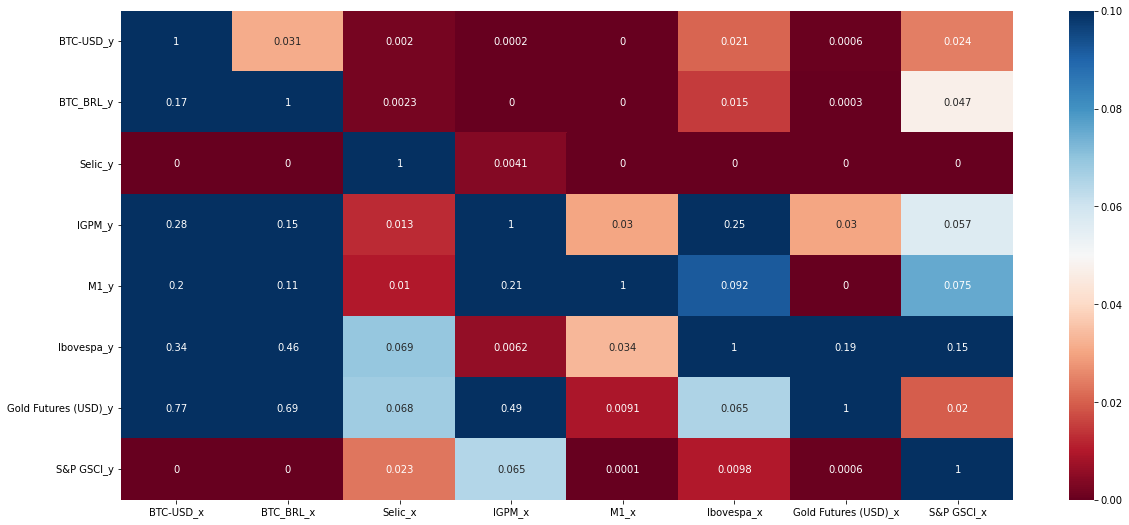

In [82]:
plt.figure(figsize = [20,9])

sns.heatmap(granger,cmap="RdBu",vmin=0, vmax=0.1,center = 0.05,annot=True)

#As linhas são as respostas enquanto as colunas são os fenômenos que podem causar essas respostas. O número indicado para cada quadro é o Valor-P 
#para cada par de eventos. Por exemplo na primeira linha observamos os fenômenos que causam o Bitcoin, caso o P-Value seja menor que 0,05;
#rejeitamos a hipótese nula de que não há causalidade para um nível de significancia (α) de 5%. Sendo assim, consideramos que variações no fenômeno observado
#causam variações no preço do Bicoin (testam positivo no teste de granger).
#Indicações Azuis indicam que o P-Value está acima do nível mínimo de significança(α). É improvável que o fenomeno x tenha causado o fenômeno y.
#Já para as indicações vermelhas e laranjas, o P-Value está abaixo de α, indicando que a hipótese nula deve ser 
#rejeitada e existe causalidade no sentido de que o fenômeno x tenha causado o fenômeno y

In [83]:
df_btc_granger

,BTC-USD,BTC_BRL,Selic,IGPM,M1,Ibovespa,Gold Futures (USD),S&P GSCI
339,407.182428,944.955658,10.900000,0.20,327925378.0,58278.227273,1235.128569,588.767613
340,364.148873,889.788258,10.921739,0.28,329034213.0,54342.826087,1222.930425,548.779565
341,366.099799,929.805640,11.150000,0.98,331258675.0,53575.894737,1176.178942,521.864213
342,341.267871,900.852215,11.581818,0.62,362152876.0,50007.500000,1200.168174,449.579543
343,248.782547,654.410049,11.816667,0.76,343797138.0,48369.380952,1252.924994,388.270499
...,...,...,...,...,...,...,...,...
430,41435.319661,196112.579772,11.650000,1.41,599813109.0,115022.052632,1933.930005,740.148001
431,31706.105217,157290.027180,12.513636,0.52,597297282.0,107809.227273,1845.938099,764.009048
432,24383.685482,122712.920991,12.888095,0.59,601904463.0,103746.571429,1834.547619,773.668091
433,21539.253843,115697.486594,13.150000,0.21,598041462.0,99108.571429,1729.800000,677.345505


In [84]:
#Em seguida, olhamos mais de perto possíveis as causas do Bitcoin com P-value menor que 0,05

In [85]:
granger_btc = grangers_causation_matrix(df_btc_granger[['BTC-USD','Selic','IGPM','M1','Ibovespa','Gold Futures (USD)','S&P GSCI']], variables = df_btc_granger[['BTC-USD','Selic','IGPM','M1','Ibovespa','Gold Futures (USD)','S&P GSCI']].columns)

In [86]:
granger_btc[:1] 

#Causas do Bitcoin pelo teste de Granger e seus respectivos valor-P

,BTC-USD_x,Selic_x,IGPM_x,M1_x,Ibovespa_x,Gold Futures (USD)_x,S&P GSCI_x
BTC-USD_y,1.0,0.002,0.0002,0.0,0.0208,0.0006,0.0243


In [87]:
df_corr[['BTC-USD','Selic','IGPM','M1','Ibovespa','Gold Futures (USD)','S&P GSCI']].corr()[:1] 

#Correlações dessas variáveis com o Bitcoin

,BTC-USD,Selic,IGPM,M1,Ibovespa,Gold Futures (USD),S&P GSCI
BTC-USD,1.0,-0.413076,0.298005,0.865502,0.750769,0.779238,0.616871
